In [9]:
%matplotlib inline

import numpy as np
import mosek
import math
import matplotlib.pyplot as plt
import sys
import time 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from skimage.draw import ellipsoid
from numpy import linalg, random, ones, zeros, eye, dot
from numpy.linalg import norm,inv,cholesky
from sklearn.cross_validation import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple
from multiprocessing import Pool

initial_rho = 1.0
max_iter = 15
max_coord_iter = 35
initial_step_size = .1
timer_thresh = .5
ep = .00000001

def kernel(x1,x2):
    return math.exp(-1*math.pow(norm(x1-x2),2
                               )/(2*math.pow(sigma, 2)))

def kernel_vect(x_list,x2):
    return np.exp(-1*np.power(norm(x_list-x2,axis=1),2 )/(2*math.pow(sigma, 2)))

def loss_vect(t,rho):
    return np.power(np.maximum(np.zeros(t.shape), np.absolute(rho - t) - delta ),2)

def f(args):
    return f_expand(*args)

def f_expand(x_data, x_test, beta,rho):
    start = time.time()

    w = np.dot(beta,kernel_vect(x_data,x_test)) - rho

    end = time.time()
    if end - start > timer_thresh:
        print 'f:',end - start,'sec'
    return w

def f_vect(slabSVM, x_test_matrix, beta,rho):
    start = time.time()

    w = np.empty(x_test_matrix.shape[0])
    for i in range(x_test_matrix.shape[0]):
        w[i] = np.dot(kernel_vect(slabSVM.x_data,x_test_matrix[i,:]),beta) - rho

    end = time.time()
    if end - start > timer_thresh:
        print 'f_vect:',end - start,'sec'
    return w

def step(element,step_size,resid):
    return element - (step_size * resid)

def incomplete_cholesky_decomp(K,G):
    start = time.time()

    assert K.shape[0] == K.shape[1]
    n = K.shape[0]

    k=-1

    np.fill_diagonal(G[0:n,0:n], np.diagonal(K[0:n,0:n]))
    
    for i in range(n):
        if i<100 and np.sum(np.diagonal(G[i:n,i:n])) > .5:
            j = np.argmax(np.diagonal(G[i:n,i:n]))+i

            temp = K.T[0:n,i].copy()
            K.T[0:n,i] = K.T[0:n,j]
            K.T[0:n,j] = temp

            temp = K.T[i,0:n].copy()
            K.T[i,0:n] = K.T[j,0:n]
            K.T[j,0:n] = temp

            temp = G[i,0:i+1].copy()
            G[i,0:i+1] = G[j,0:i+1]
            G[j,0:i+1] = temp

            G[i,i] = math.sqrt(K[i,i])

            G[i+1:n,i] = 1/G[i,i]*(K[i+1:n,i]- np.dot(G[i+1:n,0:i],G[i,0:i]) )

            
            np.fill_diagonal(G[i:n,i:n], np.diagonal(K[i:n,i:n]) - np.sum(np.power(G[i:n,0:i],2),axis=1))
        else:
            k=i
            break

    end = time.time()
    if end - start > timer_thresh:
        print 'product_form_cholesky_decomp:', end - start, 'sec'
    return G,k


# class Primal_Opt:
class Slab_SVM:

    def get_H(self,opt_on):
        start = time.time()

        if opt_on == 'b':
            start1 = time.time()
            ret = gamma*2*self.K 
            end1 = time.time()
            if end1 - start1 > timer_thresh:
                print 'get_H - part I:',end1 - start1,'sec'

            start1 = time.time()
            ret += 2/(v)*self.K_K
            end1 = time.time()
            if end1 - start1 > timer_thresh:
                print 'get_H - part II:',end1 - start1,'sec'
            
        elif opt_on == 'rho':
            ret = 2/(v*self.m)

        end = time.time()
        if end - start > timer_thresh:
            print 'get_H:',end - start,'sec'
        return ret

    def loss_der_der(self,t,rho):
        if abs(rho - t) < delta:
            return 0
        else:
            return 2

    def loss_der(self,grad,t,rho,opt_on):
        grad=0
        if opt_on=='b':
            if rho - t > delta:
                grad = -2.0*(rho - t - delta)
            if -rho + t > delta:
                grad = 2.0*(-rho + t - delta)
            return grad
        if opt_on=='rho':
            if rho - t > delta:
                grad = 2.0*(rho - t - delta)
            if -rho + t > delta:
                grad = -2.0*(-rho + t - delta)
            return grad
        raise Exception(grad,g_loss_type,t,rho,delta)
        
    def loss_der_vect(self,t,rho,opt_on):
        grad = np.zeros(t.shape)
#         grad[ np.absolute(rho - t) <= delta ] = 0
        if opt_on=='b':
            grad[ rho - t > delta ] = -2.0*(rho - t[rho - t > delta] - delta)
            grad[ -rho + t > delta ] = 2.0*(-rho + t[-rho + t > delta] - delta)
            return grad
        if opt_on=='rho':
            grad[ rho - t > delta ] = 2*(rho - t[rho - t > delta] - delta)
            grad[ -rho + t > delta ] = -2*(-rho + t[-rho + t > delta] - delta)
            return grad
        raise Exception(grad,g_loss_type,t,rho,delta)

    def z(self,x1,w,b):
#         w = random.normal(0, 1.0/sigma, size=(D,len(x1)))
#         b = random.uniform(0,2*np.pi,size=D)
        return math.sqrt(2.0/D) * np.cos(np.dot(w, x1) + b)

    def obj_funct(self,beta,rho):
        start = time.time()
        
        obj = gamma*np.dot(beta,np.dot(self.K,beta)) + \
                        1.0 / (v*self.m) * np.sum( loss_vect(np.dot(self.K,beta), rho)) - rho

        end = time.time()
        if end - start > timer_thresh:
            print 'obj_funct:',end - start,'sec'
        return obj

    def backtrack_step_size(self,step_size,obj,resid,grad,beta,rho,opt_on):    
        start = time.time()
        
        min_step_size = sys.float_info.epsilon*3
        
        if step_size == min_step_size:
            step_size = initial_step_size
        else:
            step_size *= 2**20

        iters=0
#         c = .000001
#(c*step_size*np.dot(grad, resid)) + \
        while obj <=        (self.obj_funct( step(beta,step_size,resid),rho) if opt_on=='b' \
                             else self.obj_funct( beta, step(rho,step_size,resid)) ):
            iters += 1
            step_size = step_size * 0.7
            if step_size < min_step_size:
    #             print 'WARNING: step size not found'
                step_size = min_step_size
                end = time.time()
#                 if end - start > timer_thresh:
                print 'backtrack_step_size:',end - start,'sec iters',iters,'opt_on',opt_on,\
                            ' WARNING: step size not found'
                return step_size

        assert obj > (self.obj_funct( step(beta,step_size,resid),rho) if opt_on=='b' \
                             else self.obj_funct( beta, step(rho,step_size,resid)) )

        end = time.time()
        if end - start > timer_thresh:
            print 'backtrack_step_size:',end - start,'sec, iters',iters,'opt_on',opt_on
        return step_size
    
    
#     def numer_grad(self,beta,rho,ep,direct=0,opt_on=''): # const
#         if opt_on == 'rho':
#             return (obj_funct(beta,rho+ep) \
#                    -obj_funct(beta,-rho*ep))/(2*ep)
#         return (obj_funct(beta+(ep*direct),rho) \
#                -obj_funct(beta-(ep*direct),rho))/(2*ep)

#     def grad_checker(self,beta,rho,ep,opt_on): # const
#         start = time.time()

#         if opt_on == 'rho':
#             return numer_grad(beta,rho,ep,opt_on=opt_on)

#         d=len(beta)
#         w=np.zeros(d)
#         for i in range(d):
#             direct=np.zeros(beta.shape)
#             direct[i] = 1
#             w[i]=(numer_grad(beta,rho,ep,direct=direct,opt_on=opt_on))

#         end = time.time()
#         if end - start > timer_thresh:
#             print 'grad_checker:',end - start,'sec'        
#         return w
    
    def timed_solve(self,A,B):
        start = time.time()
        
        ret = linalg.solve(A,B)
        
        end = time.time()
        if end - start > timer_thresh:
            print 'timed_solve:',end - start,'sec'
        return ret

    def get_resid(self,beta,rho,grad,loss_vect_list,opt_on):
#         start = time.time()
#         self.H = self.get_H(beta,rho,loss_vect_list,opt_on)
        
        if opt_on=='b':

            if is_approx:
                H_copy = self.H.copy()
                start = time.time()
                incomplete_cholesky,k = incomplete_cholesky_decomp(H_copy,
                                                                   np.zeros(self.K.shape))
                print 'k',k
                # resid = L' \ L \ grad
                resid = self.timed_solve(incomplete_cholesky.T,self.timed_solve(incomplete_cholesky,grad))
                end = time.time()
                if end - start > timer_thresh:
                    print 'solve - incomplete_cholesky_decomp:',end - start,'sec'
            else:
                start = time.time()
                if Use_Cholesky:
                    L = cholesky(self.H)
    #                 assert np.allclose(self.H, np.dot(L,L.T.conj()),atol=.001,rtol=.001)
                    # resid = L' \ L \ grad
                    resid = self.timed_solve(L.T,self.timed_solve(L,grad))
                else:
#                     resid = self.timed_solve(self.H,grad)
                    resid = np.dot(self.H_inv,grad)
                end = time.time()
                if end - start > timer_thresh:
                    print 'resid:',end - start,'sec'

#                 assert np.allclose(resid,resid2,atol=.001,rtol=.001)
        else:
            resid = grad #/self.H

#         end = time.time()
#         if end - start > timer_thresh:
#             print 'get_resid:',end - start,'sec'
        return resid

    def obj_grad(self,opt_on):
        start = time.time()
        
        if opt_on == 'b':
#             grad = 2.0*np.dot(self.K,self.beta) + 1.0/(v*self.m)*np.sum(
#                                                                 np.multiply(self.K , self.loss_der_vect(
#                                                                                              self.grad_buffer,
#                                                                                            np.dot(self.K,self.beta),
#                                                                                              self.rho,
#                                                                                              opt_on)),
#                                                                              axis=0)
            grad = gamma*2.0*np.dot(self.K,self.beta)
            for i in range(self.m):
                grad += 1.0/(v*self.m)* (self.K[i] * self.loss_der( 0, np.dot(self.K[i],self.beta),
                                                                                  self.rho,
                                                                                  opt_on))
#             print 'abs(norm(grad)-norm(grad2))',abs(norm(grad)-norm(grad2))
#             assert np.allclose(grad,grad2)
                                                                             
        elif opt_on == 'rho':
            grad = 1/(v*self.m)*np.sum(self.loss_der_vect( np.dot(self.K,self.beta),self.rho, opt_on) )-1

        else:
            print '[obj_grad] Error'
        
        end = time.time()
        if end - start > timer_thresh:
            print 'obj_grad:',end - start,'sec'
        return grad
    
    def grad_des_iterate(self,opt_on='b'):
        start = time.time()
        loss_vect_list = np.where(np.absolute(self.rho - np.dot(self.K,self.beta)) >= delta)[0]            
        end = time.time()
        if end - start > timer_thresh:
            print 'find sv:',end - start,'sec'

        obj = self.obj_funct(self.beta,self.rho)
#         print 'obj',obj
        if obj < -self.rho:
            raise Exception(obj)
#         self.obj_array[self.iterations]=(obj)

        self.grad = self.obj_grad(opt_on)
#         print 'grad',norm(self.grad)
#         print

#         self.obj_grad_array[self.iterations]=norm(self.grad)
        
#         print 'norm(self.grad)',norm(self.grad)
#         if self.iterations>2:
#             print 'norm(self.grad) diff', \
#                             abs(self.obj_grad_array[self.iterations]/self.obj_grad_array[self.iterations-1])
        if norm(self.grad) < (min_grad_rho if opt_on == 'rho' else min_grad_beta):
            print 'Stopping crit: norm(grad) small',norm(self.grad),'opt_on',opt_on
            return True

        resid = self.get_resid(self.beta,self.rho,self.grad,loss_vect_list,opt_on)

        if opt_on == 'rho':
            self.step_size_rho = self.backtrack_step_size(self.step_size_rho,obj,resid,self.grad,self.beta,
                                                          self.rho,opt_on)
            self.rho = max(0, step(self.rho,self.step_size_rho,resid)) # Update
        else:
            self.step_size_beta = self.backtrack_step_size(self.step_size_beta,obj,resid,self.grad,self.beta,
                                                           self.rho,opt_on)
            self.beta = step(self.beta, self.step_size_beta, resid) # Update
            
        end = time.time()
        if end - start > timer_thresh:
            print 'grad_des_iterate:',end - start,'sec'

        return False

    def grad_des_coord(self, opt_on=''):
        start = time.time()
        for j in range(max_coord_iter): #max_iter if i<max_iter-1 else 2*max_iter):
            self.iterations += 1
            converged = self.grad_des_iterate(opt_on=opt_on)
            if converged:
                break
        end = time.time()
        if end - start > timer_thresh:
            print 'grad_des_coord:',end - start,'sec'
        return converged
    
    def grad_des(self):
        start = time.time()

        self.obj_array = -1*np.ones(max_iter)
        self.obj_grad_array = np.zeros((max_iter))
        self.obj_grad_check_array = np.zeros(max_iter)

        self.beta = zeros(self.m)
        self.rho = initial_rho

        self.grad_buffer = zeros(self.beta.shape)
        self.step_size_beta = initial_step_size
        self.step_size_rho = initial_step_size
        self.iterations = 0
        print 'obj', self.obj_funct(self.beta,self.rho)
        
        for i in range(max_iter):
            
            converged_b = self.grad_des_coord(opt_on='b')

            converged_rho = self.grad_des_coord(opt_on='rho')
            
#             for j in range(max_iter): # if i<max_iter-1 else 2*max_iter):
#                 self.iterations += 1
#                 converged_rho = self.grad_des_iterate(opt_on='rho')
#                 if converged_rho:
#                     break
            
            
            print 'obj', self.obj_funct(self.beta,self.rho)

            print 'grad b', norm(self.obj_grad('b')), 'grad rho', norm(self.obj_grad('rho'))

            print 'b', norm(self.beta), 'rho', self.rho
            
            print 'self.iterations',self.iterations
            
            if norm(self.obj_grad('b')) < min_grad_beta and norm(self.obj_grad('rho')) < min_grad_rho:
                print 'Stopping crit: norm(grad) small, opt_on b and rho'
                return True
            
            if i == max_iter-1:
                print 'WARNING: Did not converge'

        end = time.time()
#         if end - start > timer_thresh:
        print 'grad_des:',((str(end - start)+' sec') if end - start < 60 else (str((end - start)/60.)+' min'))
#         return Run(self.obj_array,self.obj_grad_array,self.obj_grad_check_array,self.beta,self.rho,iterations)

    def pop_K(self):
        start = time.time()
        
        self.K=np.zeros((self.m,self.m))
        
#         if Fourier_Feature:
#             z_cache = np.zeros((self.m,D))
#             w = random.normal(0, 1.0/sigma, size=(self.m*D,len(self.x_data[0])))
#             b = random.uniform(0,2*np.pi,size=self.m*D)
#             for i in range(self.m):
#                 z_cache[i]=self.z(self.x_data[i],w[i:i+D,:],b[i:i+D])
#             end = time.time()
#             if end - start > timer_thresh:
#                 print 'z_cache:',end - start,'sec'

#             for i in range(self.m):
# #                 for j in range(self.m):
#                 self.K[i,:] = np.dot(z_cache,z_cache[i])
# #                         self.z(self.x_data[i]),self.z(self.x_data[j]))
#         else:
        for i in range(self.m):
            self.K[i,:] = kernel_vect(self.x_data,self.x_data[i])
        

#         if Fourier_Feature:
#             K_test=np.zeros((self.m,self.m))
#             for i in range(self.m):
#                 K_test[i,:] = kernel_vect(self.x_data,self.x_data[i])

#             print 'Fourier norm diff', norm(K_test-self.K)
            
        self.K_K = np.dot(self.K, self.K)
        
        self.H = self.get_H('b')

        self.H_inv = inv(self.H)
        
        end = time.time()
        if end - start > timer_thresh:
            print 'pop_K:',end - start,'sec'

    def get_K_inv(K):
        start = time.time()

        K_inv = inv(K)

        end = time.time()
        if end - start > timer_thresh:
            print 'get_K_inv:',end - start,'sec'
        return K_inv

    def get_K_cond(K):
        start = time.time()

        K_cond = linalg.cond(K)

        end = time.time()
        if end - start > timer_thresh:
            print 'get_K_cond:',end - start,'sec'
        return K_cond

    def pre_comp_K():
        start = time.time()

        K = get_K()    

        end = time.time()
        if end - start > timer_thresh:
            print 'pre_comp_K:',end - start,'sec'
        return K #, K_inv

    def __init__(self, x_data):
        start = time.time()
        self.x_data = x_data
        self.m = len(self.x_data)
        self.pop_K()
        if np.min(linalg.eigvals(self.K))<0:
            raise Exception(linalg.eigvals(self.K))
        if np.min(linalg.eigvalsh(self.K))<0:
            raise Exception(linalg.eigvalsh(self.K))
        self.grad_des()
        end = time.time()
        if end - start > timer_thresh:
            print '__init__:',((str(end - start)+' sec') if end - start < 60 else (str((end - start)/60.)+' min'))
        
def get_data_points(data_ratio):
    start = time.time()

    x = []
    f = open('bunny.obj.txt')
    for line in f:
        line = line.strip()
        if line != '' and line[0] != '#':
            line_split = line.split()
            if len(line_split)==4 and line_split[0] == 'v':
                x.append(line_split[1:])
    x = np.array(x)
    x=x.astype(np.float)
    x = sorted(x, key=lambda a_entry: a_entry[0]) 
    x = np.array(x)
    x = x[data_ratio*x.shape[0]/10:,:]
    print 'points:',len(x)
    
    end = time.time()
    if end - start > timer_thresh:
        print 'get_data_points:',end - start,'sec'
    return x
    
grid_steps = 150

def proc_data(beta,rho,data):
    start = time.time()

    print 'delta',delta
    print 'rho',rho
    print 'np.abs(data - delta) < .1 -> ',(np.where(np.abs(data - delta) < .1)[0].shape)
    print 'np.abs(data - delta) < .01 -> ',(np.where(np.abs(data - delta) < .01)[0].shape)
    print 'np.abs(data - delta) < .001 -> ',(np.where(np.abs(data - delta) < .001)[0].shape)
    print 'np.abs(data - delta) < .0001 -> ',(np.where(np.abs(data - delta) < .0001)[0].shape)
    print 'data < delta -> ',(np.where(data < delta )[0].shape)
    print 'data > delta -> ',(np.where(data > delta )[0].shape)
    print 'data < 0 -> ',(np.where( data < 0)[0].shape)
    print 'data == 0 -> ',(np.where( data == 0)[0].shape)
    print 'data > 0 -> ',(np.where( data > 0)[0].shape)
    print 'min -> ',(np.amin( data ))
    print 'max -> ',(np.amax( data ))
#     print 'data:',data
    
    end = time.time()
    if end - start > timer_thresh:
        print 'proc_results:',end - start

def pop_data_grid(slabSVM, beta,rho,x0_max,x1_max,x2_max,x0_min,x1_min,x2_min):
    start = time.time()
    data = np.zeros((grid_steps,grid_steps,grid_steps))

    x0_range = np.linspace(x0_min, x0_max, grid_steps)
    x1_range = np.linspace(x1_min, x1_max, grid_steps)
    x2_range = np.linspace(x2_min, x2_max, grid_steps)
    
    end = time.time()
    if end - start > timer_thresh:
        print 'alloc mem:',end - start

    pool = Pool(processes=4)

    args = []
    for i in range(grid_steps):
        for j in range(grid_steps):
            for k in range(grid_steps):
                args.append((slabSVM.x_data, 
                             np.asarray([x0_range[i],
                                         x1_range[j],
                                         x2_range[k]]), 
                             slabSVM.beta,
                             slabSVM.rho,))
                
#                 data[i,j,k] = f((slabSVM.x_data, np.asarray([x0_range[i],
#                                 x1_range[j],
#                                 x2_range[k]]), beta,rho))
    end = time.time()
    if end - start > timer_thresh:
        print 'pop_data_grid args:',end - start,'sec'

    eval_map = pool.map(f, args)
    
    end = time.time()
    if end - start > timer_thresh:
        print 'pop_data_grid pool map:',end - start,'sec'

    counter=0
    for i in range(grid_steps):
        for j in range(grid_steps):
            for k in range(grid_steps):
                data[i,j,k] = eval_map[counter]
                counter += 1
                
    end = time.time()
    if end - start > timer_thresh:
        print 'pop_data_grid:',end - start,'sec'
    return data    
    

points: 2503


/Users/mich/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


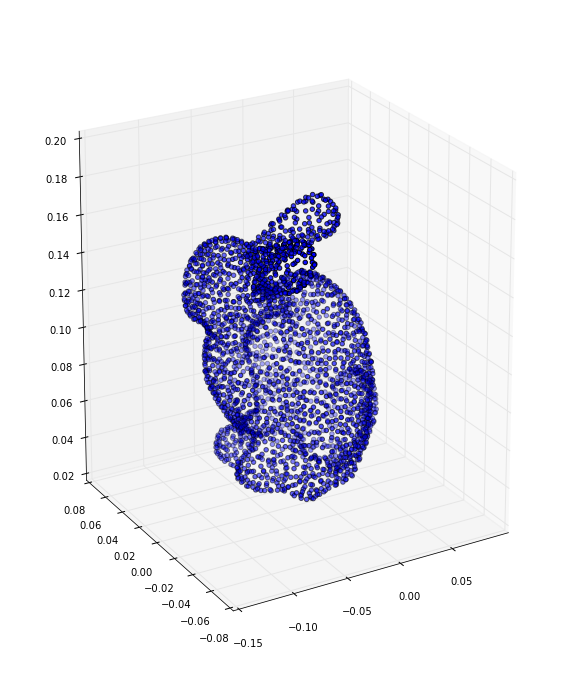

scatter: 0.882488012314 sec
-----------------------------------
v 0.0001
sigma 0.0084
gamma 1.0
pop_K: 2.96001195908 sec
obj 9999.0
grad_des_coord: 9.86819791794 sec
grad_des_coord: 8.58791303635 sec
obj 19.446749785
grad b 4.31407307641 grad rho 0.00151441322202
b 3489.45386247 rho 0.0474121535925
self.iterations 70
grad_des_coord: 9.88239002228 sec
Stopping crit: norm(grad) small 6.58564812972e-06 opt_on rho
grad_des_coord: 6.33776187897 sec
obj 0.274010649902
grad b 4.32641259574 grad rho 6.58564812972e-06
b 105.267601701 rho 0.04739729569
self.iterations 132
grad_des_coord: 9.87803888321 sec
Stopping crit: norm(grad) small 8.45918026271e-06 opt_on rho
grad_des_coord: 6.21972990036 sec
obj 0.240246783277
grad b 4.33863943466 grad rho 8.45918026271e-06
b 21.5943288821 rho 0.0473822858561
self.iterations 192
grad_des_coord: 9.89227199554 sec
Stopping crit: norm(grad) small 8.26831437184e-06 opt_on rho
grad_des_coord: 6.31242179871 sec
obj 0.233898704986
grad b 4.3501195598 grad rho 8.

In [2]:
g_loss_type = 'square-hinge'
g_method = 'Newton'
g_Desc = {}
g_counter=0

approx_avg = []
true_avg = []
approx_iterations = []
true_iterations = []

v = .0001
sigma = .0084
gamma = 1.
delta = 0.0
is_approx = False
Use_Cholesky = False
data_ratio = 0
min_grad_beta = 0.00001
min_grad_rho =  0.00001
# for is_approx in [False]: #True, False]:
#     for data_ratio in [0]:#,1,2,4,6,8]:
g_x = get_data_points(data_ratio)

start = time.time()
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(g_x[:,0],g_x[:,2],g_x[:,1])
ax.view_init(elev=20., azim=240)
plt.show()
end = time.time()
if end - start > timer_thresh:
    print 'scatter:',end - start,'sec'

g_counter += 1

print '-----------------------------------'        
print 'v',v
print 'sigma',sigma
print 'gamma',gamma
g_Desc[g_counter] = Slab_SVM(g_x)
print 'obj',g_Desc[g_counter].obj_funct(g_Desc[g_counter].beta,g_Desc[g_counter].rho)
print 'norm(grad)',norm(g_Desc[g_counter].obj_grad('b'))
print 'Desc iterations',g_Desc[g_counter].iterations
print 'Desc rho',g_Desc[g_counter].rho
print '-----------------------------------'
print 

In [10]:
g_m = len(g_x)

start = time.time()
losses = []
for i in range(g_m):
    losses.append(f((g_Desc[g_counter].x_data, g_x[i], g_Desc[g_counter].beta, g_Desc[g_counter].rho)))
losses = np.asarray(losses)
end = time.time()
if end - start > timer_thresh:
    print 'losses = []:',end - start,'sec'

if is_approx:
    approx_avg.append(np.average( losses ))
    approx_iterations.append(g_Desc[g_counter].iterations)
else:
    true_avg.append(np.average( losses ))
    true_iterations.append(g_Desc[g_counter].iterations)

print 'losses min -> ',(np.amin( losses ))
print 'losses argmin -> ',(np.argmin( losses ))
print 'losses x[min] -> ',g_x[(np.argmin( losses ))]
print 'losses max -> ',(np.amax( losses ))
print 'losses argmax -> ',(np.argmax( losses ))
print 'losses x[max] -> ',g_x[(np.argmax( losses ))]
print 'v',v
print 'sigma',sigma

x0_max = np.amax(g_x[:,0])
x0_min = np.amin(g_x[:,0])
x1_max = np.amax(g_x[:,1])
x1_min = np.amin(g_x[:,1])
x2_max = np.amax(g_x[:,2])
x2_min = np.amin(g_x[:,2])

data = pop_data_grid(g_Desc[g_counter], g_Desc[g_counter].beta,g_Desc[g_counter].rho,
                     x0_max,x1_max,x2_max,x0_min,x1_min,x2_min)

proc_data(g_Desc[g_counter].beta,g_Desc[g_counter].rho,data)


losses = []: 0.542112827301 sec
losses min ->  -0.00162914606797
losses argmin ->  1072
losses x[min] ->  [-0.04246598  0.0341891  -0.02726065]
losses max ->  0.00194953175144
losses argmax ->  1119
losses x[max] ->  [-0.03948189  0.03361822 -0.02361247]
v 0.0001
sigma 0.0084
pop_data_grid args: 11.7918810844 sec
pop_data_grid pool map: 398.109637022 sec
pop_data_grid: 399.015020132 sec
delta 0.0
rho 0.0472015434133
np.abs(data - delta) < .1 ->  (3375000,)
np.abs(data - delta) < .01 ->  (705195,)
np.abs(data - delta) < .001 ->  (204158,)
np.abs(data - delta) < .0001 ->  (27293,)
data < delta ->  (3196281,)
data > delta ->  (178719,)
data < 0 ->  (3196281,)
data == 0 ->  (0,)
data > 0 ->  (178719,)
min ->  -0.0472015434133
max ->  0.00800866447699


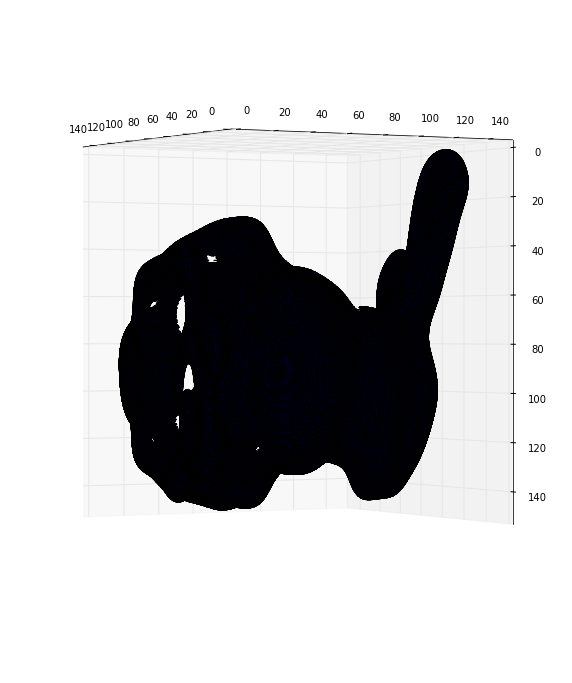

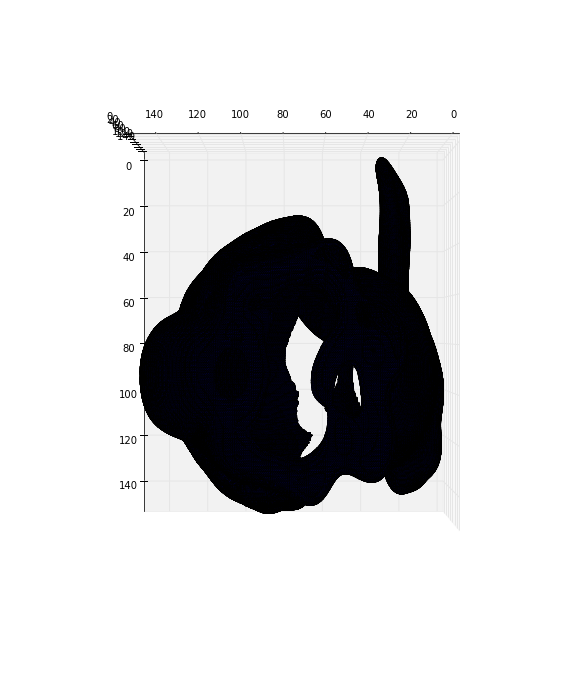

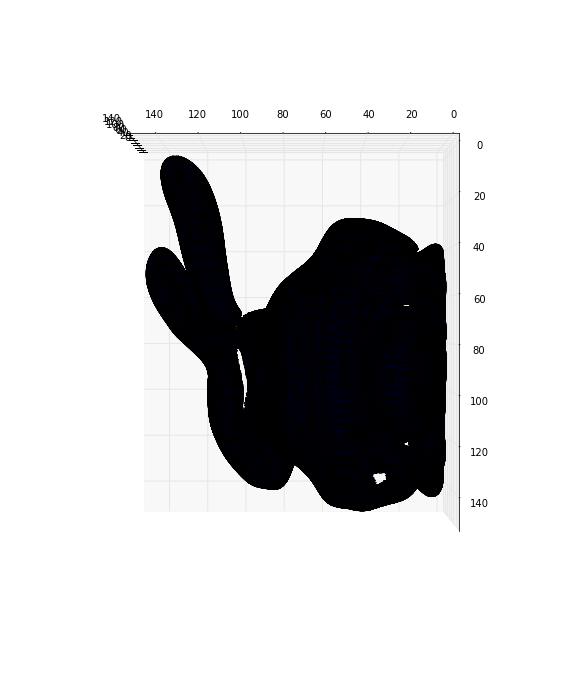

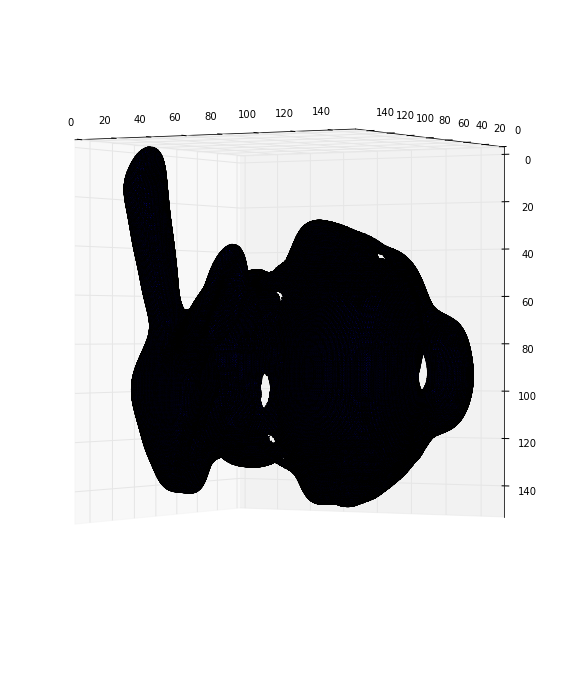

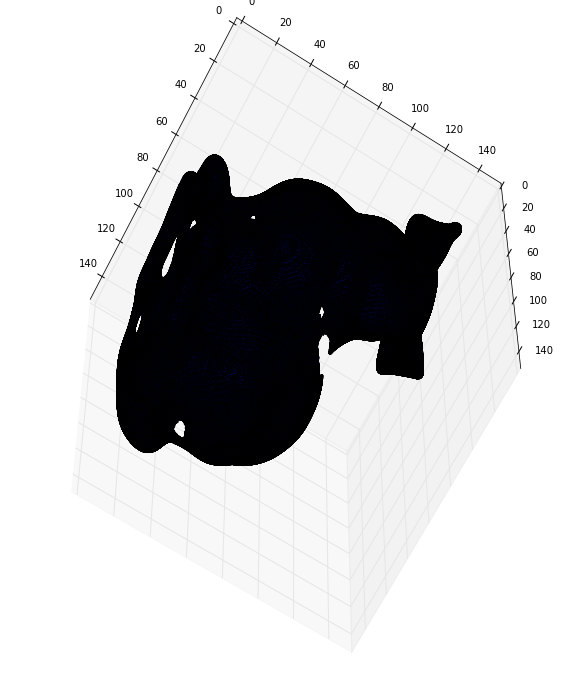

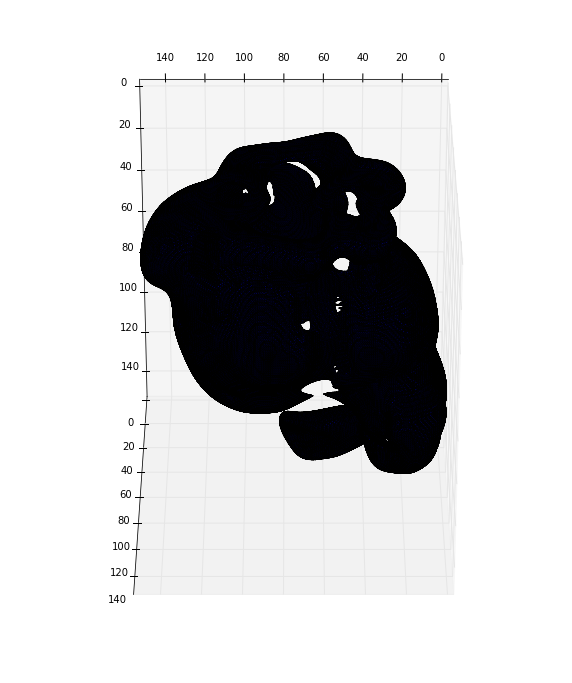

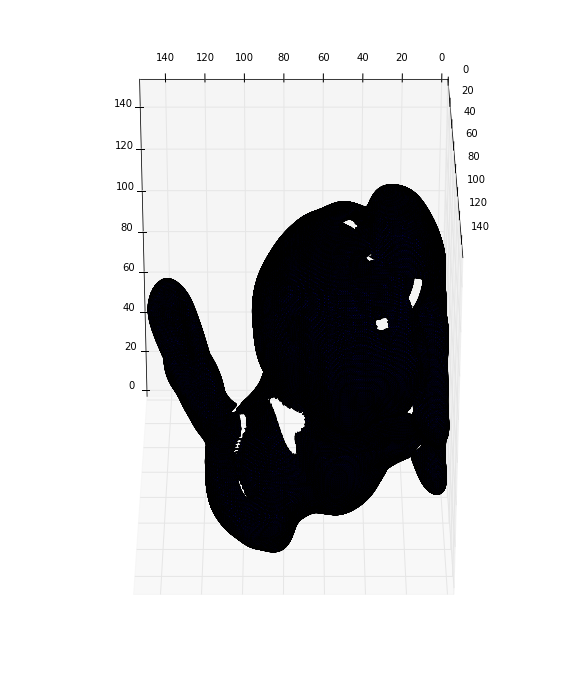

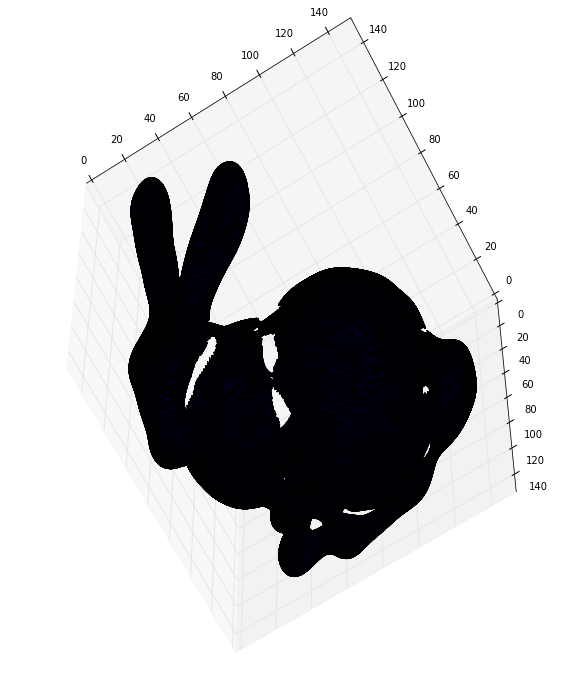

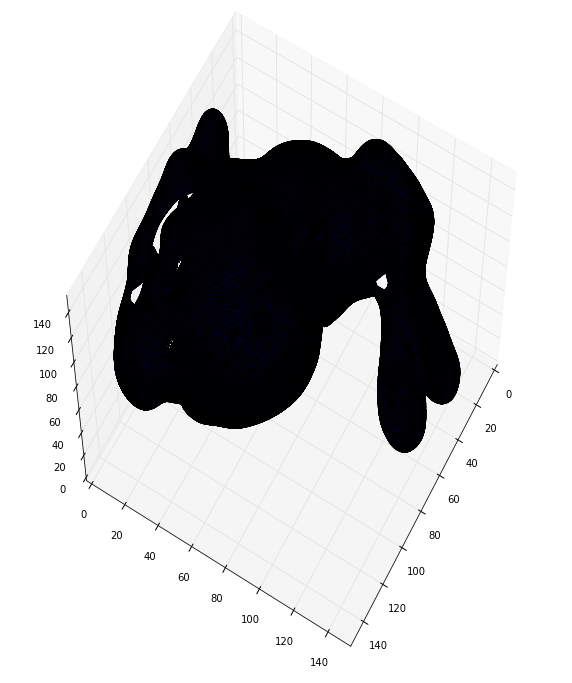

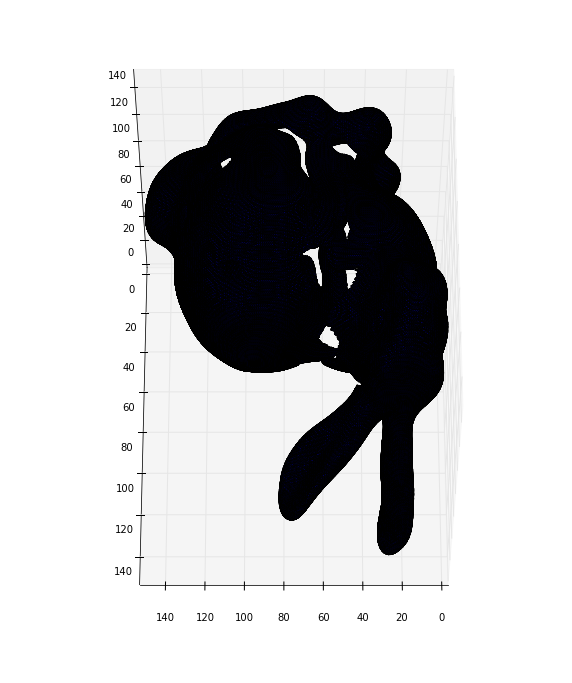

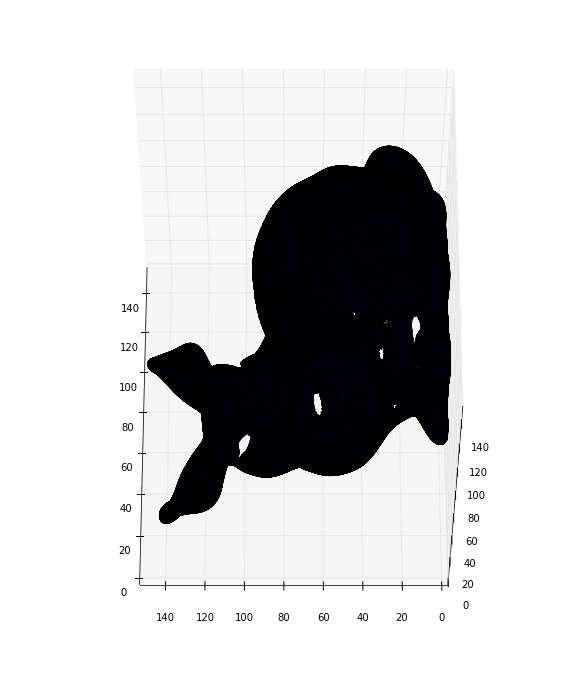

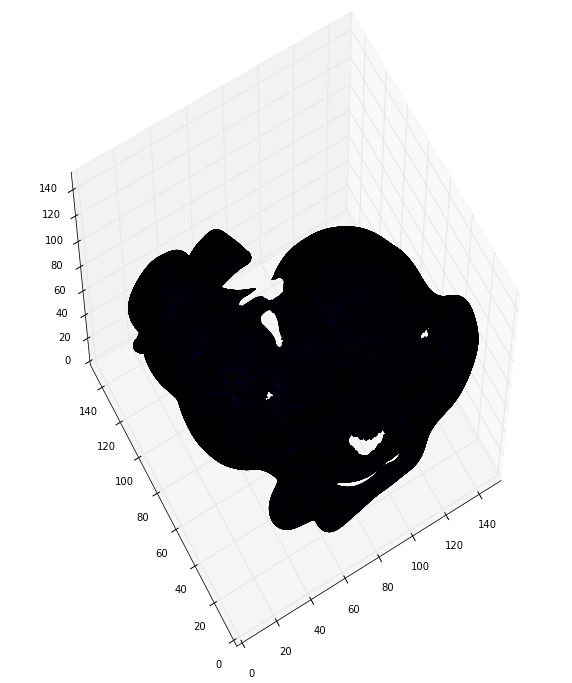

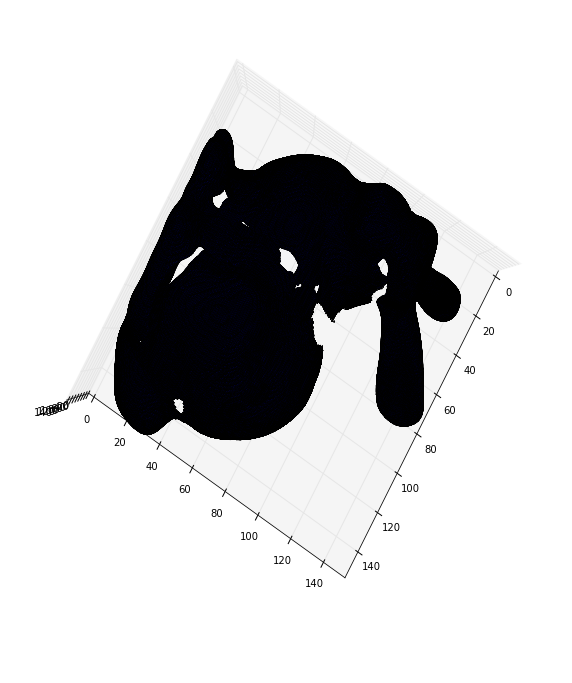

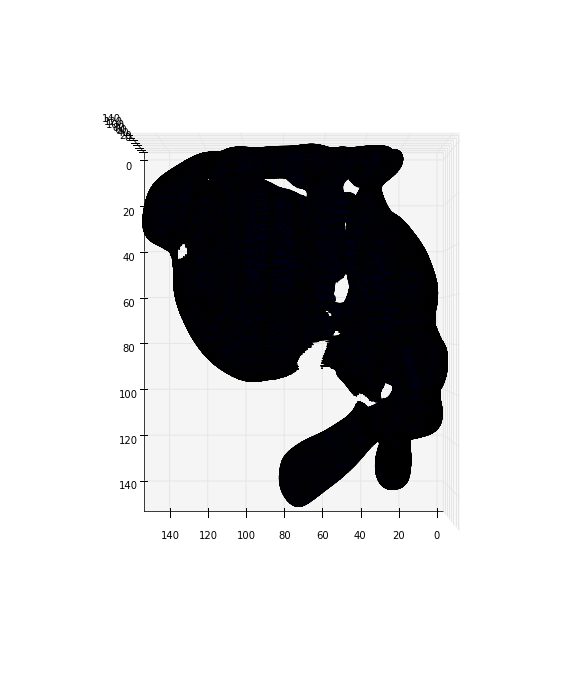

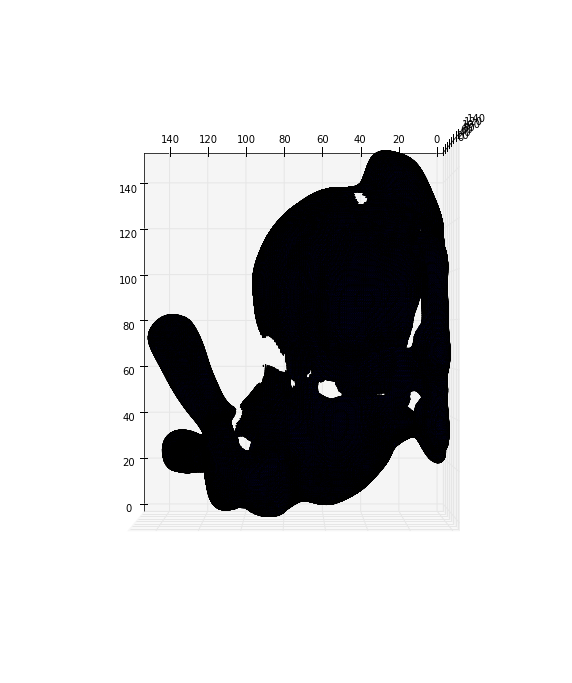

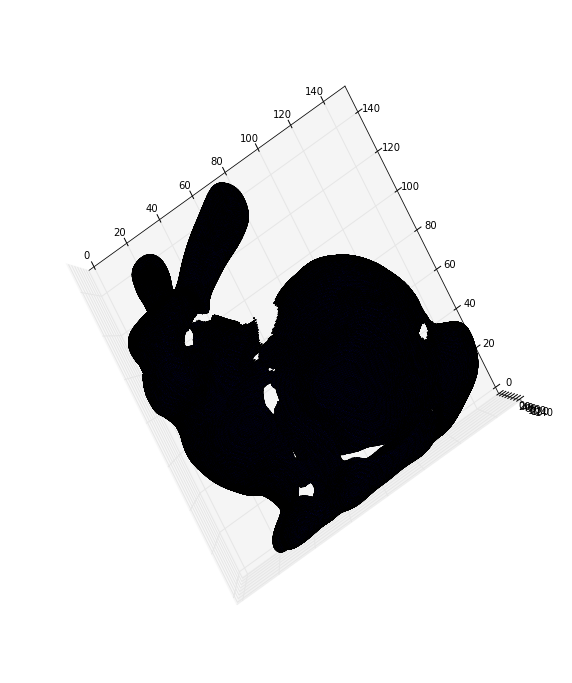

In [12]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces = measure.marching_cubes(data, 0)

for elev in [180,120,60,90]:
    for azim in [30,90,180,240]:
        # Display resulting triangular mesh using Matplotlib. This can also be done
        # with mayavi (see skimage.measure.marching_cubes docstring).
        fig = plt.figure(figsize=(10, 12))
        ax = fig.add_subplot(111, projection='3d')

        # Fancy indexing: `verts[faces]` to generate a collection of triangles
        mesh = Poly3DCollection(verts[faces])
        ax.add_collection3d(mesh)
        ax.view_init(elev=elev, azim=azim)

        ax.set_xlim(0,grid_steps)  
        ax.set_ylim(0,grid_steps)  
        ax.set_zlim(0,grid_steps)  

        plt.show()


(150, 150, 150)
[[  0  85  98]
 [  0  85  99]
 [  0  85 100]
 ..., 
 [149  32  92]
 [149  32  93]
 [149  32  94]]
(53705, 3)


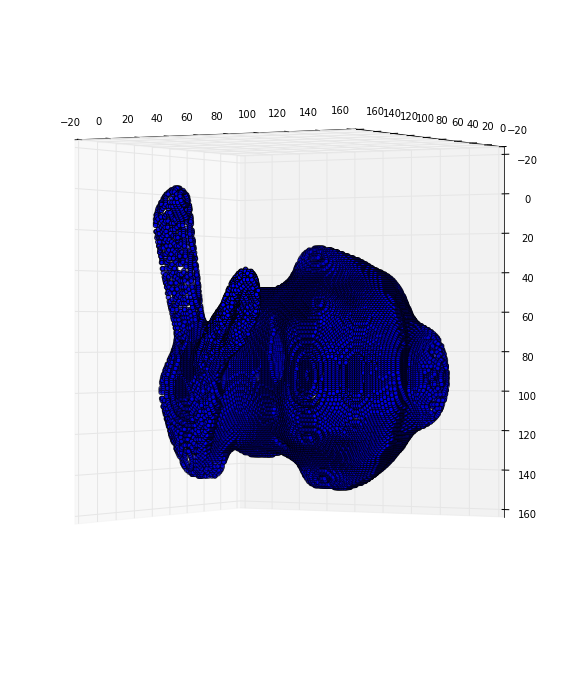

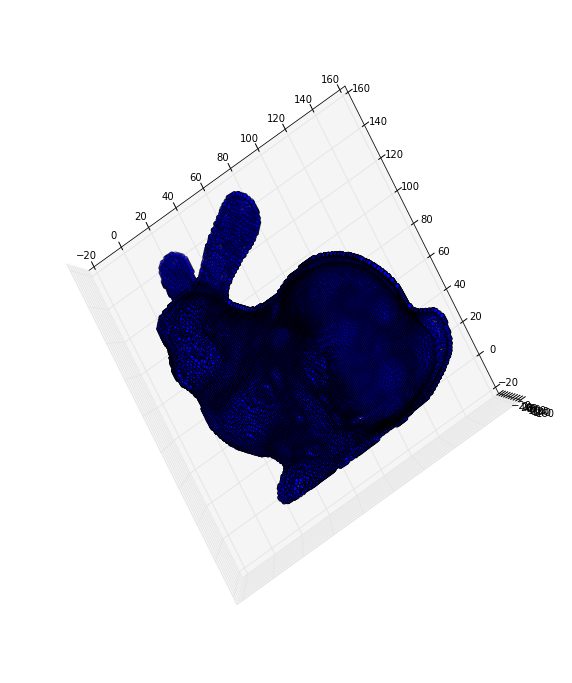

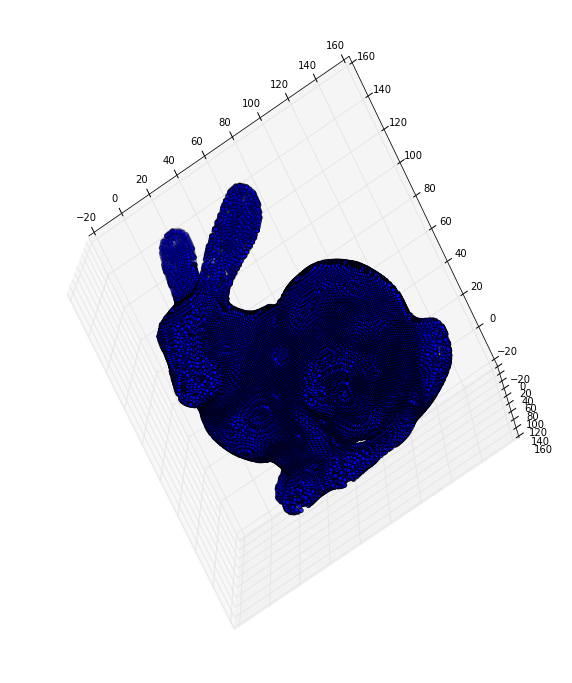

In [15]:
surface_data = []
for i in range(grid_steps):
    for j in range(grid_steps):
        for k in range(grid_steps):
            if abs(data[i,j,k]) < .0002:
                surface_data.append([i,j,k])
surface_data = np.asarray(surface_data)
print surface_data.shape

fig1 = plt.figure(figsize=(10, 12))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.scatter(surface_data[:,0],surface_data[:,1],surface_data[:,2])
ax1.view_init(elev=180., azim=240)
plt.show()

fig2 = plt.figure(figsize=(10, 12))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(surface_data[:,0],surface_data[:,1],surface_data[:,2])
ax2.view_init(elev=90., azim=240)
plt.show()

fig3 = plt.figure(figsize=(10, 12))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.scatter(surface_data[:,0],surface_data[:,1],surface_data[:,2])
ax3.view_init(elev=100., azim=240)
plt.show()


In [ ]:
# data = pop_data_grid(g_Desc[g_counter].beta,g_Desc[g_counter].rho,g_Desc[g_counter].f,
#                      x0_max,x1_max,x2_max,x0_min,x1_min,x2_min)
from mayavi import mlab
s = mlab.mesh(data)
mlab.show()


In [ ]:
# the histogram of the data
print data[50,50,:]
print data.shape

n, bins, patches = plt.hist(data[50,50,:], 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
l = plt.plot(bins)#, y, 'r--', linewidth=1)

# plt.xlabel('Smarts')
# plt.ylabel('Probability')
# plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
# plt.axis([40, 160, 0, 0.03])
# plt.grid(True)

plt.show()

In [ ]:
%matplotlib nbagg
plt.clf()
plt.cla()

ax = plt.subplot(1,1,1)

print  approx_avg 
print  true_avg 
# approx_iterations = []
# true_iterations = []

ax.scatter(range(1,len(approx_avg)+1),
           approx_avg,marker='^',
           label='Approximate Low Rank Kernel')
ax.scatter(range(1,len(true_avg)+1),
           true_avg,marker='*',
           label='Exact Kernel')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.title('Average Error vs Data Size')
plt.ylabel('Average Error')
plt.xlabel('Data Size')


In [ ]:
%matplotlib nbagg
plt.clf()
plt.cla()

ax = plt.subplot(1,1,1)

print  approx_iterations 
print  true_iterations 

ax.scatter(range(1,len(approx_iterations)+1),
           approx_iterations,marker='^',
           label='Approximate Low Rank Kernel')
ax.scatter(range(1,len(true_iterations)+1),
           true_iterations,marker='*',
           label='Exact Kernel')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.title('Descent Iterations vs Data Size')
plt.ylabel('Descent Iterations')
plt.xlabel('Data Size')


In [ ]:
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(g_x[:,0],g_x[:,2],g_x[:,1])
ax.view_init(elev=20., azim=240)
plt.show()


In [ ]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces = measure.marching_cubes(data, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")

ax.set_xlim(-1, 30)  
ax.set_ylim(-1, 30)  
ax.set_zlim(-1, 30)  

ax.view_init(elev=20., azim=240)

plt.show()
